In [1]:
import h5py
import numpy as np

In [2]:
def load_dataset(path,filename):
    f = h5py.File(path+filename)
    input_dataset = np.asarray([f[element[0]][:] for element in f['input_dataset']])
    output_dataset = np.asarray([f[element[0]][:] for element in f['output_dataset']])
    f.close()
    return input_dataset,output_dataset

In [3]:
path = './data/'
filename = 'dataset_batch_1.mat'
input_dataset,output_dataset = load_dataset(path,filename)
print(input_dataset.shape,output_dataset.shape)

(869, 200, 128, 128) (869, 128, 128)


In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

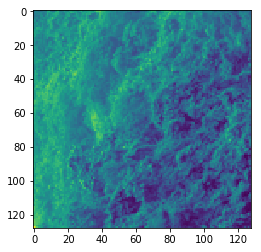

In [5]:
plt.imshow(output_dataset[100,:,:])

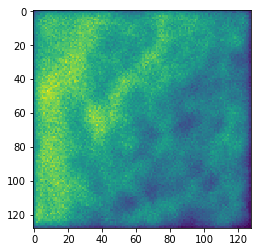

In [6]:
plt.imshow(input_dataset[100,100,:,:])

In [9]:
import torch
from torch import nn, optim
from torch.autograd import Variable

In [10]:
# Linear Regression Model
class FullyConvNet(nn.Module):
    def __init__(self):
        super(FullyConvNet, self).__init__()
        self.conv1 = nn.Conv2d(200, 100,kernel_size=5, stride=1,padding=2)  # input and output is 1 dimension
        self.conv2 = nn.Conv2d(100, 50,kernel_size=7, stride=1,padding=3)
        self.conv3 = nn.Conv2d(50, 10,kernel_size=7, stride=1,padding=3)
        self.conv4 = nn.Conv2d(10, 1,kernel_size=3, stride=1,padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        out_layer1 = self.relu(self.conv1(x))
        out_layer2 = self.relu(self.conv2(out_layer1))
        out_layer3 = self.relu(self.conv3(out_layer2))
        out = self.conv4(out_layer3)
        return out

In [13]:
model = FullyConvNet()
model = nn.DataParallel(model)
model.cuda()

# criterion = nn.MSELoss()
criterion = nn.SmoothL1Loss()
# optimizer = optim.SGD(model.parameters(), lr=1e-9)
optimizer = optim.Adam(model.parameters(), lr=1e-5)

# in_data = np.asarray(np.transpose(input_dataset[:100,:,:,:],(0,1,2,3)),dtype=np.float32)
# out_data = np.asarray(np.reshape(output_dataset[:100,:,:],(-1,1,128,128)),dtype=np.float32)
# x_train = torch.from_numpy(in_data)
# y_train = torch.from_numpy(out_data)

In [14]:
# 开始训练
num_epochs = 100000
batch_size = 40
batch_num_max = 20
for epoch in range(num_epochs):
    for batch_num in range(batch_num_max):
        in_data = np.asarray(np.transpose(input_dataset[batch_num*batch_size:batch_num*batch_size+batch_size,:,:,:],(0,1,2,3)),dtype=np.float32)
        out_data = np.asarray(np.reshape(output_dataset[batch_num*batch_size:batch_num*batch_size+batch_size,:,:],(-1,1,128,128)),dtype=np.float32)
        x_train = torch.from_numpy(in_data)
        y_train = torch.from_numpy(out_data)
        
        inputs = Variable(x_train).cuda()
        target = Variable(y_train).cuda()

        # forward
        out = model(inputs)
        loss = criterion(out, target)
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1) % 20 == 0:
        print('Epoch[{}/{}], loss: {:.6f}'
              .format(epoch+1, num_epochs, loss.data[0]))


/home/weixin/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:25: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch[20/100000], loss: 0.021942
Epoch[40/100000], loss: 0.012571
Epoch[60/100000], loss: 0.009775
Epoch[80/100000], loss: 0.008827
Epoch[100/100000], loss: 0.008146
Epoch[120/100000], loss: 0.006901
Epoch[140/100000], loss: 0.006397
Epoch[160/100000], loss: 0.005901
Epoch[180/100000], loss: 0.005491
Epoch[200/100000], loss: 0.005140
Epoch[220/100000], loss: 0.004827
Epoch[240/100000], loss: 0.004506
Epoch[260/100000], loss: 0.004234
Epoch[280/100000], loss: 0.003978
Epoch[300/100000], loss: 0.003773
Epoch[320/100000], loss: 0.003632
Epoch[340/100000], loss: 0.003395
Epoch[360/100000], loss: 0.003368
Epoch[380/100000], loss: 0.003124
Epoch[400/100000], loss: 0.003027
Epoch[420/100000], loss: 0.002904
Epoch[440/100000], loss: 0.002829
Epoch[460/100000], loss: 0.002744
Epoch[480/100000], loss: 0.002689
Epoch[500/100000], loss: 0.002603
Epoch[520/100000], loss: 0.002544
Epoch[540/100000], loss: 0.002496
Epoch[560/100000], loss: 0.002450
Epoch[580/100000], loss: 0.002410
Epoch[600/100000],

KeyboardInterrupt: 

In [15]:
model.eval()
predict = model(Variable(x_train).cuda())
predict = predict.data.cpu().numpy()

In [16]:
print(np.shape(predict))
print(type(predict))
print(np.shape(predict[0,0,:,:]))

(40, 1, 128, 128)
<class 'numpy.ndarray'>
(128, 128)


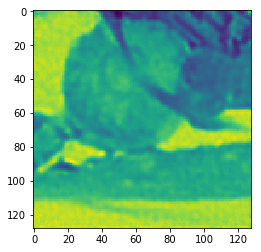

In [21]:
plt.imshow(predict[31,0,:,:])

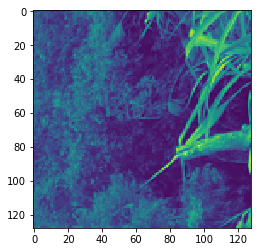

In [19]:
plt.imshow(output_dataset[30,:,:])

In [ ]:
plt.imshow(input_dataset[10,50,:,:])

In [ ]:
test_data = np.asarray(np.transpose(input_dataset[100:200,:,:,:],(0,1,2,3)),dtype=np.float32)
test_data = torch.from_numpy(test_data)
predict_test = model(Variable(test_data).cuda())
predict_test = predict_test.data.cpu().numpy()
plt.imshow(predict_test[29,0,:,:])

In [ ]:
plt.imshow(output_dataset[129,:,:])

In [ ]:
plt.imshow(input_dataset[129,50,:,:])